In [1]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
sns.set()
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise, Input, PReLU, Activation, Concatenate
from keras.models import load_model
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

In [3]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df[df.z > 10]
df = df.dropna()

In [4]:
# large-scale parameters, should be included
F1 = [
    'dewpoint', 'spec_hum', 'press', 'temp', 'air_dens', 
    'virtual_temp', 'rel_hum', 'rain', 'z', 'wind', 'soil_temp'
]

# radiation, no idea but probably should not include
F2 = [
    'co2flux', 'soilheat', 'netrad'
]

# fluxes, better if not included
F3 = [
    'H', 'LE',
]

# we must be desperate to use these to make it work
F4 = [
    'lval', #'zL', 'ustar'
]

features = F1 + F2 #+ F3 + F4

target = 'phi_m'

In [25]:
def make_index(dtimes, interval):
    # returns a tuple index_above, index_below
    # index_above[i] is the largest i
    # such that dtimes[index_above[i]] - dtimes[i] < interval
    # index_below[i] is the smallest i
    # such that dtimes[i] - dtimes[index_below[i]] < interval
    # dtimes must be already sorted!
    index_below, index_above = np.zeros(
        (2, len(dtimes)), dtype=np.int
    ) - 1
    
    for i, x in enumerate(dtimes):
        j = index_below[i - 1] if i > 0 else 0
        while x - dtimes[j] > interval:
            j += 1

        index_below[i] = j
        index_above[j] = i

    last_above = index_above[0]
    for i in range(len(dtimes)):
        if index_above[i] < 0:
            index_above[i] = last_above
        else:
            last_above = index_above[i]
    
    return index_above, index_below


def compute_trend(df, columns, interval=3600):
    df = df.sort_values('datetime')
    for z in df.z.unique():  
        sorted_df = df[df.z == z]
        index_above, index_below = make_index(sorted_df.datetime.values, interval)

        for col in columns:
            val_above = sorted_df.iloc[index_above][col].values
            val_below = sorted_df.iloc[index_below][col].values

            time_above = sorted_df.iloc[index_above].datetime.values
            time_below = sorted_df.iloc[index_below].datetime.values

            trend = 2 * interval * (val_above - val_below) / (time_above - time_below)

            df.loc[df.z == z, col + '_trend'] = trend
            #df.loc[df.z == z, col + '_trend_1'] = sorted_df.index[index_above]
            #df.loc[df.z == z, col + '_trend_2'] = sorted_df.index[index_below]
            #df.loc[df.z == z, col + '_trend_3'] = time_above - time_below

    return df, [col + '_trend' for col in columns]


use_trend = False
if use_trend:
    ddf, added_cols = compute_trend(df, [
        f.replace('_trend', '') for f in features
        if f != 'z'
    ])
    ddf = ddf.dropna()
    features.extend(added_cols)
else:
    features = [f for f in features if 'trend' not in f]
    ddf = df


features = list(set(features))    
print('using features', features)

using features ['rel_hum', 'soil_temp', 'virtual_temp', 'soilheat', 'netrad', 'temp', 'wind', 'spec_hum', 'dewpoint', 'z', 'co2flux', 'air_dens', 'press', 'rain']


In [26]:
test_ds = np.random.choice(ddf.ds.unique(), 12, replace=False)
test_mask = ddf.ds.isin(test_ds)
train_x, train_y = ddf[~test_mask][features], ddf[~test_mask][target]
test_x, test_y = ddf[test_mask][features], ddf[test_mask][target]

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 805946, testing with 61741


In [27]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [28]:
assert np.all(np.isfinite(norm_train_x))

In [68]:
def build_model(sizes):
    # ever element in sizes specifies a layer
    #   negative number: skip connection of -n layers
    #                    successive skips are aggregated
    #                    into a single layer
    #   0<n<1: dropout with pkeep=n
    #   >1 fully connected then prelu
    layers = [Input(shape=(len(features),))]
    i = 0
    while i < len(sizes):
        num = sizes[i]
        if num < 0:
            skip = [layers[-1]]
            while sizes[i] < 0:
                skip.append(layers[sizes[i] - 1])
                i += 1
            layer = Concatenate()(skip)
            i -= 1
        elif num < 1:
            layer = Dropout(num)(layers[-1])
        else:
            layer = PReLU()(
                Dense(num)(
                    layers[-1]
                )
            )

        layers.append(layer)
        i += 1

    layers.append(Dense(1)(layers[-1]))
        
    opt = Adam(lr=0.001)
    model = Model(inputs=layers[0], outputs=layers[-1])
    model.compile(loss='mse', optimizer=opt)
    return model


model = build_model([
    512, 512, -2, 0.5,
    256, 256, -4, 0.5,
    128, 128, -4, 0.5,
    64, 64, -4, 0.5,
    32, 32, -4, 0.5,
    16, 16, -4,
    16, 16, -4,
    16, 16, -4,
    8, 8, -4,
    8, 8, -4,
    8, 8,
])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
dense_391 (Dense)               (None, 512)          7680        input_24[0][0]                   
__________________________________________________________________________________________________
p_re_lu_387 (PReLU)             (None, 512)          512         dense_391[0][0]                  
__________________________________________________________________________________________________
dense_392 (Dense)               (None, 512)          262656      p_re_lu_387[0][0]                
__________________________________________________________________________________________________
p_re_lu_38

In [69]:
callbacks = [
    ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
    ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                    verbose=1, save_best_only=True),
    TensorBoard('dev/logs/', write_graph=False, write_grads=True),
    EarlyStopping(min_delta=0.0001, patience=30),
]

hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=2048, epochs=250,
    shuffle=True,
    callbacks=callbacks,
    validation_data=(norm_test_x, norm_test_y)
)

Train on 805946 samples, validate on 61741 samples
Epoch 1/250
804864/805946 [============================>.] - ETA: 0s - loss: 0.3136
Epoch 00001: val_loss improved from inf to 0.26081, saving model to dev/models/weights-w.0001-0.2608.hdf5
805946/805946 [==============================] - 30s 37us/step - loss: 0.3135 - val_loss: 0.2608
Epoch 2/250
804864/805946 [============================>.] - ETA: 0s - loss: 0.2464
Epoch 00002: val_loss did not improve
805946/805946 [==============================] - 17s 21us/step - loss: 0.2464 - val_loss: 0.2719
Epoch 3/250
804864/805946 [============================>.] - ETA: 0s - loss: 0.2386
Epoch 00003: val_loss improved from 0.26081 to 0.25731, saving model to dev/models/weights-w.0003-0.2573.hdf5
805946/805946 [==============================] - 17s 22us/step - loss: 0.2386 - val_loss: 0.2573
Epoch 4/250
804864/805946 [============================>.] - ETA: 0s - loss: 0.2335
Epoch 00004: val_loss did not improve
805946/805946 [===============

KeyboardInterrupt: 

In [71]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

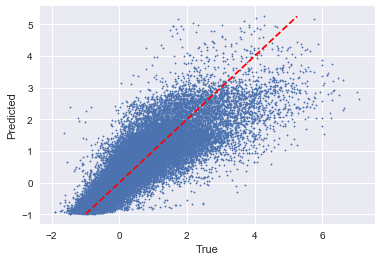

Explained variance 0.7663479802445482
Mean absolute error 0.5837759815795177
Mean squared error 0.8266960317132703
Median absolute error 0.36088669889173053
R2 score 0.7658393389062026
Mean absolute percent error [115.78177]


In [81]:
best_model = load_model('dev/models/weights-w.0011-0.2514.hdf5')
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

plot_preds(y_pred, norm_test_y)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)